In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

import os

2024-10-15 20:35:59.432299: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 20:35:59.486307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 20:35:59.486349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 20:35:59.488401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 20:35:59.497059: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 20:35:59.498036: I tensorflow/core/platform/cpu_feature_guard.cc:1


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [2]:
model_names = [
    #"f_r_embed_input_d5_static_0.0005_28j",
    #"f_r_penult_mult_d5_static_0.0005_Ag0",
    "f_r_penult_sum_d5_static_0.0005_370",
    "f_r_single_both_d5_static_0.0005_GTs",
    "f_r_single_mult_d5_static_0.0005_JT1",
    "f_r_single_sum_d5_static_0.0005_F8t",
    "f_r_FiLM_reduced_d5_static_0.0005_9vG",
    "f_r_FiLM_full_d5_static_0.0005_XOr",
    "f_r_token_mult_d5_static_0.0005_eW4",
    "0.1107_f_r_token_sum_d5_static_0.0005_9I4",
    "f_r_single_token_d5_static_0.0005_lm6",
    "f_r_multi_token_d5_static_0.0005_RvL",
]

model_labels = [name.split('_r_')[1].split('_d5_')[0] for name in model_names]
model_labels

custom_palette = {
    'penult_sum'    : "brown",
    'single_both'   : "grey",
    'single_mult'   : "grey",
    'single_sum'    : "grey",
    'FiLM_reduced'  : "green",
    'FiLM_full'     : "green",
    'token_mult'    : "orange",
    'token_sum'     : "orange",
    'single_token'  : "purple",
    'multi_token'   : "purple",
}

In [7]:
print(model_names[5])

model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_names[5],
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()


print(len(int_data.tensor_train_data))
print(len(int_data.tensor_val_data))

f_r_single_sum_d5_static_0.0005_F8t
Model: "transformer_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             multiple                  6656      
                                                                 
 dense_6 (Dense)             multiple                  3328      
                                                                 
 dense_7 (Dense)             multiple                  65792     
                                                                 
 trans_block_5 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_6 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_7 (TransBlock)  multiple                  524545    
                                                                 
 trans_bloc

In [3]:
int_data = FragmentIonIntensityDataset.load_from_disk("/cmnfs/proj/prosit_astral/datasets/_dlomix_saved/full_dataset")

In [4]:
losses = []

eval_batches = [m for m in int_data.tensor_val_data.take(2)]

for model_name in model_names:

    model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_name,
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
    
    pred = []
    true = []
    
    for j in range(0, len(eval_batches)):
    
        predictions = model.predict(eval_batches[j][0], verbose=0)
    
        pred += np.split(predictions,        predictions.shape[0], axis=0) 
        true += np.split(eval_batches[j][1], predictions.shape[0], axis=0) 
    
    pred = np.concatenate(pred, axis=0)
    true = np.concatenate(true, axis=0)
    
    print('Loss: ', tf.reduce_mean( masked_spectral_distance(true, pred) ))

    losses.append(masked_spectral_distance(true, pred))

print(losses)

Loss:  tf.Tensor(0.11068027, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10536687, shape=(), dtype=float32)
Loss:  tf.Tensor(0.105747946, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10804893, shape=(), dtype=float32)
Loss:  tf.Tensor(0.112146765, shape=(), dtype=float32)
Loss:  tf.Tensor(0.106130846, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10583858, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10766454, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10595432, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10683932, shape=(), dtype=float32)
[<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.02740276, 0.13804853, 0.11117673, ..., 0.03686016, 0.03835006,
       0.05804122], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.01733022, 0.12754469, 0.10577754, ..., 0.05172935, 0.03353242,
       0.06361057], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.01783858, 0.10208219, 0.11496042, ..., 0.02712   , 0.03145358,
       0.06138211],

In [5]:
import pandas as pd
import numpy as np


test = pd.DataFrame({
    'method': np.repeat(model_labels, len(losses[0])),
    'loss': 1 - tf.concat(losses, axis=0),
})

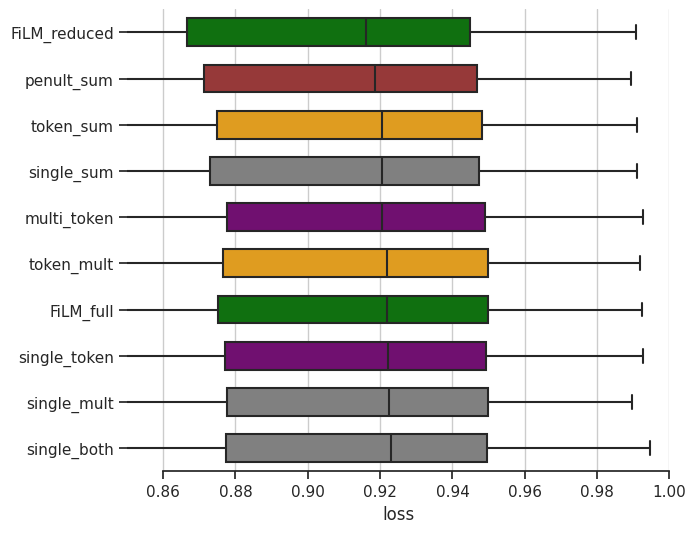

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

ax.set_xlim(0.85, 1)

method_order = test.groupby('method')['loss'].median().sort_values().index

sns.boxplot(
    test, x="loss", y="method",
    order=method_order,  # Order y-axis by median loss
    whis=[0, 100], width=.6, palette=custom_palette
)


# Add in points to show each observation
#sns.stripplot(test, x="loss", y="method",order=method_order, size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)